# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

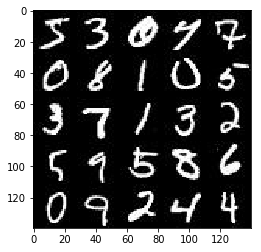

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

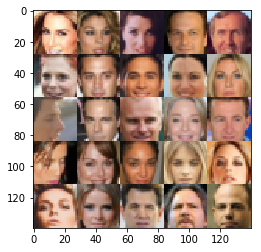

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.4.0
Default GPU Device: /device:GPU:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_images = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_images')
    z = tf.placeholder(tf.float32, (None, z_dim), name='z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')

    return input_images, z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [15]:
def discriminator(images, reuse=False, alpha = .2):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        # input layer is 28*28*3
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        x1 = tf.maximum(alpha*x1, x1)
        # 14*14*64
        
        x2 = tf.layers.conv2d(x1, 128, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=True)
        x2 = tf.maximum(alpha*x2, x2)
        # 7*7*128
        
        x3 = tf.layers.conv2d(x2, 256, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=True)
        x3 = tf.maximum(alpha*x3, x3)
        
        flat = tf.reshape(x3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 128)
        logits = tf.layers.dense(logits, 1)
        out = tf.sigmoid(logits)

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [16]:
def generator(z, out_channel_dim, is_train=True, alpha = .2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse=not is_train):
        x1 = tf.layers.dense(z, 7*7*512)
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(x1*alpha, x1)
        # 7*7*512
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=1, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(x2*alpha, x2)
        # 14*14*256
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(x3*alpha, x3)
        
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='same')
        out = tf.tanh(logits)
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [17]:
def model_loss(input_real, input_z, out_channel_dim, alpha=0.2):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim, alpha=alpha)
    d_model_real, d_logit_real = discriminator(input_real, alpha=alpha)
    d_model_fake, d_logit_fake = discriminator(g_model, reuse=True, alpha=alpha)
    
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logit_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logit_fake, labels=tf.zeros_like(d_model_fake)))
    
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logit_fake, labels=tf.ones_like(d_model_fake)))
    d_loss = d_loss_real + d_loss_fake
    
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [18]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [19]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [20]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    n_samples, width, height, channels = data_shape
    input_real, input_z, learn_rate = model_inputs(width, height, channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, learn_rate, beta1)
    
    steps = 0
    show_every = 50
    print_every = 10
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                batch_images *= 2.0
                _ = sess.run([d_opt, g_opt], feed_dict={input_real: batch_images, input_z: batch_z, 
                                                        learn_rate: learning_rate})
                if steps % show_every == 0:
                    n_images = 25
                    show_generator_output(sess, n_images, input_z, channels, data_image_mode)

                if steps % print_every == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 0/2... Discriminator Loss: 1.6334... Generator Loss: 48.5632
Epoch 0/2... Discriminator Loss: 6.3220... Generator Loss: 36.9065
Epoch 0/2... Discriminator Loss: 0.8643... Generator Loss: 5.8827
Epoch 0/2... Discriminator Loss: 0.0633... Generator Loss: 7.9502


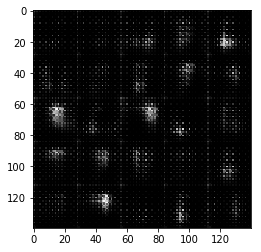

Epoch 0/2... Discriminator Loss: 4.1542... Generator Loss: 0.8243
Epoch 0/2... Discriminator Loss: 5.0697... Generator Loss: 1.1252
Epoch 0/2... Discriminator Loss: 3.7903... Generator Loss: 1.4112
Epoch 0/2... Discriminator Loss: 2.5572... Generator Loss: 1.4856
Epoch 0/2... Discriminator Loss: 2.2008... Generator Loss: 0.4277


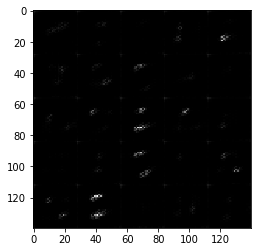

Epoch 0/2... Discriminator Loss: 2.3115... Generator Loss: 0.6260
Epoch 0/2... Discriminator Loss: 8.8357... Generator Loss: 14.4209
Epoch 0/2... Discriminator Loss: 1.0851... Generator Loss: 7.1523
Epoch 0/2... Discriminator Loss: 1.3980... Generator Loss: 4.8769
Epoch 0/2... Discriminator Loss: 1.2933... Generator Loss: 0.8088


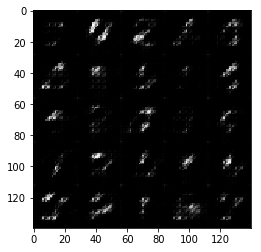

Epoch 0/2... Discriminator Loss: 3.1678... Generator Loss: 1.0690
Epoch 0/2... Discriminator Loss: 1.1044... Generator Loss: 1.9478
Epoch 0/2... Discriminator Loss: 3.4309... Generator Loss: 0.2259
Epoch 0/2... Discriminator Loss: 0.4597... Generator Loss: 2.8027
Epoch 0/2... Discriminator Loss: 1.7859... Generator Loss: 0.8203


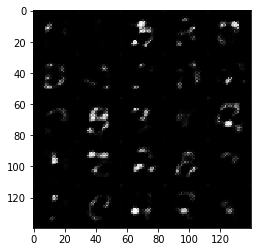

Epoch 0/2... Discriminator Loss: 0.3626... Generator Loss: 2.1520
Epoch 0/2... Discriminator Loss: 0.9132... Generator Loss: 3.3672
Epoch 0/2... Discriminator Loss: 0.8930... Generator Loss: 3.3312
Epoch 0/2... Discriminator Loss: 1.4694... Generator Loss: 0.6236
Epoch 0/2... Discriminator Loss: 2.4246... Generator Loss: 0.2299


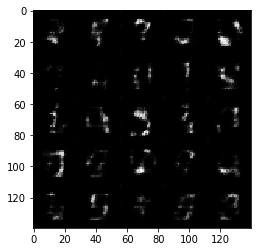

Epoch 0/2... Discriminator Loss: 1.1191... Generator Loss: 1.2363
Epoch 0/2... Discriminator Loss: 1.2045... Generator Loss: 0.6892
Epoch 0/2... Discriminator Loss: 0.8622... Generator Loss: 1.9365
Epoch 0/2... Discriminator Loss: 2.4700... Generator Loss: 0.2187
Epoch 0/2... Discriminator Loss: 2.6769... Generator Loss: 0.2585


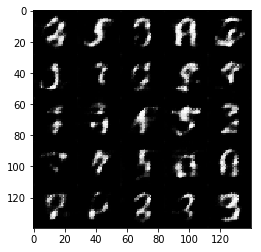

Epoch 0/2... Discriminator Loss: 1.0120... Generator Loss: 1.1055
Epoch 0/2... Discriminator Loss: 1.7298... Generator Loss: 0.5378
Epoch 0/2... Discriminator Loss: 0.7020... Generator Loss: 1.5957
Epoch 0/2... Discriminator Loss: 1.2887... Generator Loss: 3.7832
Epoch 0/2... Discriminator Loss: 1.2068... Generator Loss: 0.5504


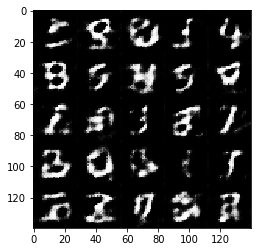

Epoch 0/2... Discriminator Loss: 1.2748... Generator Loss: 0.5466
Epoch 0/2... Discriminator Loss: 2.2898... Generator Loss: 0.2064
Epoch 0/2... Discriminator Loss: 1.1748... Generator Loss: 0.6712
Epoch 0/2... Discriminator Loss: 0.9757... Generator Loss: 0.7858
Epoch 0/2... Discriminator Loss: 0.5872... Generator Loss: 2.3819


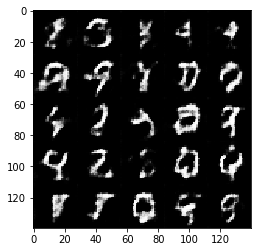

Epoch 0/2... Discriminator Loss: 0.9656... Generator Loss: 0.7721
Epoch 0/2... Discriminator Loss: 0.7054... Generator Loss: 1.4397
Epoch 0/2... Discriminator Loss: 0.9056... Generator Loss: 1.0749
Epoch 0/2... Discriminator Loss: 1.0384... Generator Loss: 0.9309
Epoch 0/2... Discriminator Loss: 3.1149... Generator Loss: 0.1146


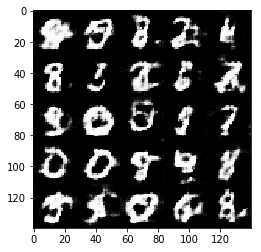

Epoch 0/2... Discriminator Loss: 1.0405... Generator Loss: 0.8216
Epoch 0/2... Discriminator Loss: 0.9938... Generator Loss: 1.9319
Epoch 0/2... Discriminator Loss: 1.5014... Generator Loss: 0.4389
Epoch 0/2... Discriminator Loss: 1.9311... Generator Loss: 4.3437
Epoch 0/2... Discriminator Loss: 1.3297... Generator Loss: 0.5736


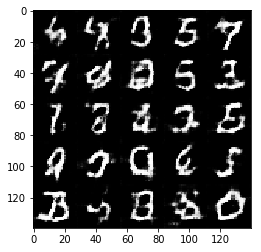

Epoch 0/2... Discriminator Loss: 2.0619... Generator Loss: 0.2122
Epoch 0/2... Discriminator Loss: 0.9929... Generator Loss: 1.9424
Epoch 0/2... Discriminator Loss: 0.7707... Generator Loss: 1.0126
Epoch 0/2... Discriminator Loss: 1.0127... Generator Loss: 0.8408
Epoch 0/2... Discriminator Loss: 1.1191... Generator Loss: 0.5746


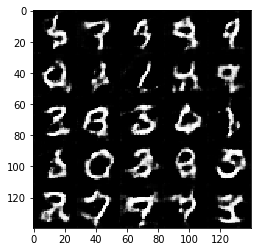

Epoch 0/2... Discriminator Loss: 0.8868... Generator Loss: 2.1206
Epoch 0/2... Discriminator Loss: 1.3935... Generator Loss: 0.4797
Epoch 0/2... Discriminator Loss: 1.1533... Generator Loss: 0.8492
Epoch 0/2... Discriminator Loss: 1.3818... Generator Loss: 0.5081
Epoch 0/2... Discriminator Loss: 0.8069... Generator Loss: 1.3521


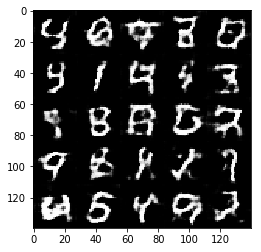

Epoch 0/2... Discriminator Loss: 0.7509... Generator Loss: 1.2651
Epoch 0/2... Discriminator Loss: 0.9691... Generator Loss: 0.7689
Epoch 0/2... Discriminator Loss: 0.6068... Generator Loss: 1.8342
Epoch 0/2... Discriminator Loss: 2.4880... Generator Loss: 0.1901
Epoch 0/2... Discriminator Loss: 0.8639... Generator Loss: 1.2853


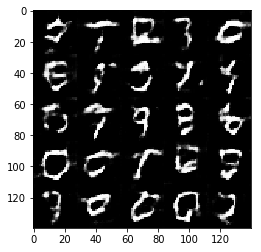

Epoch 0/2... Discriminator Loss: 0.9213... Generator Loss: 1.5976
Epoch 0/2... Discriminator Loss: 0.9525... Generator Loss: 3.4039
Epoch 0/2... Discriminator Loss: 0.3938... Generator Loss: 3.2529
Epoch 0/2... Discriminator Loss: 0.6396... Generator Loss: 1.8803
Epoch 0/2... Discriminator Loss: 2.2772... Generator Loss: 0.1921


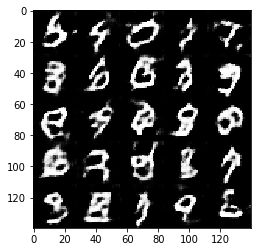

Epoch 0/2... Discriminator Loss: 0.7105... Generator Loss: 1.6961
Epoch 0/2... Discriminator Loss: 2.7330... Generator Loss: 0.1120
Epoch 0/2... Discriminator Loss: 0.5886... Generator Loss: 1.7832
Epoch 0/2... Discriminator Loss: 0.6587... Generator Loss: 1.2835
Epoch 0/2... Discriminator Loss: 1.1150... Generator Loss: 0.6758


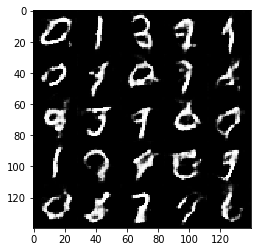

Epoch 0/2... Discriminator Loss: 0.8005... Generator Loss: 0.9108
Epoch 0/2... Discriminator Loss: 0.5285... Generator Loss: 1.5253
Epoch 0/2... Discriminator Loss: 0.7482... Generator Loss: 1.2048
Epoch 0/2... Discriminator Loss: 1.2040... Generator Loss: 0.6478
Epoch 0/2... Discriminator Loss: 0.8268... Generator Loss: 1.4003


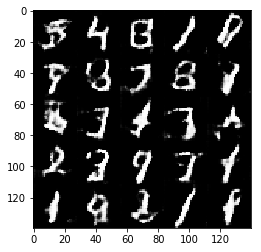

Epoch 0/2... Discriminator Loss: 1.4555... Generator Loss: 0.5556
Epoch 0/2... Discriminator Loss: 0.8259... Generator Loss: 1.0258
Epoch 0/2... Discriminator Loss: 0.9975... Generator Loss: 0.9172
Epoch 0/2... Discriminator Loss: 1.8272... Generator Loss: 0.3069
Epoch 0/2... Discriminator Loss: 0.8813... Generator Loss: 1.9887


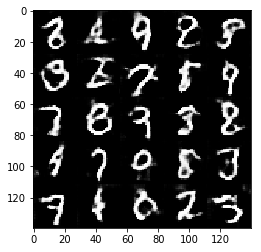

Epoch 0/2... Discriminator Loss: 0.9399... Generator Loss: 0.9347
Epoch 0/2... Discriminator Loss: 0.9048... Generator Loss: 1.1762
Epoch 0/2... Discriminator Loss: 0.8966... Generator Loss: 0.8395
Epoch 0/2... Discriminator Loss: 2.3487... Generator Loss: 0.1803
Epoch 0/2... Discriminator Loss: 0.6376... Generator Loss: 1.7357


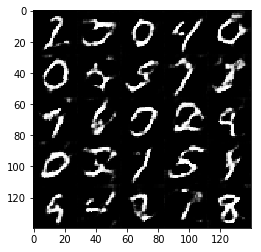

Epoch 0/2... Discriminator Loss: 0.8047... Generator Loss: 0.9420
Epoch 0/2... Discriminator Loss: 0.7317... Generator Loss: 1.2084
Epoch 0/2... Discriminator Loss: 0.6245... Generator Loss: 1.3912
Epoch 0/2... Discriminator Loss: 1.1097... Generator Loss: 0.8876
Epoch 0/2... Discriminator Loss: 1.3132... Generator Loss: 0.7210


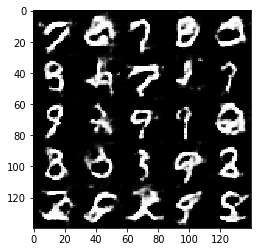

Epoch 0/2... Discriminator Loss: 0.8583... Generator Loss: 1.1180
Epoch 0/2... Discriminator Loss: 0.4860... Generator Loss: 2.3613
Epoch 0/2... Discriminator Loss: 1.5480... Generator Loss: 0.3810
Epoch 0/2... Discriminator Loss: 0.5571... Generator Loss: 1.5738
Epoch 0/2... Discriminator Loss: 1.4195... Generator Loss: 0.4243


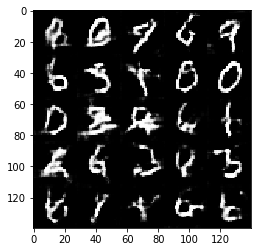

Epoch 0/2... Discriminator Loss: 2.1557... Generator Loss: 0.1928
Epoch 0/2... Discriminator Loss: 2.0050... Generator Loss: 0.2642
Epoch 0/2... Discriminator Loss: 0.7241... Generator Loss: 1.8536
Epoch 0/2... Discriminator Loss: 0.7357... Generator Loss: 1.1165
Epoch 0/2... Discriminator Loss: 1.9713... Generator Loss: 0.3278


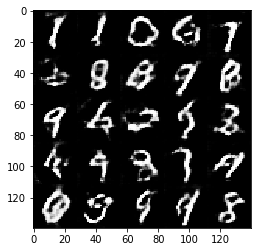

Epoch 0/2... Discriminator Loss: 0.5604... Generator Loss: 1.3801
Epoch 0/2... Discriminator Loss: 1.1101... Generator Loss: 0.7529
Epoch 0/2... Discriminator Loss: 0.9928... Generator Loss: 0.7470
Epoch 0/2... Discriminator Loss: 1.0962... Generator Loss: 0.5805
Epoch 0/2... Discriminator Loss: 1.0534... Generator Loss: 3.2727


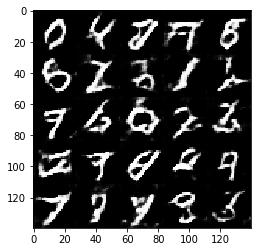

Epoch 0/2... Discriminator Loss: 0.8249... Generator Loss: 0.8831
Epoch 0/2... Discriminator Loss: 1.2113... Generator Loss: 1.2073
Epoch 0/2... Discriminator Loss: 1.1333... Generator Loss: 1.8589
Epoch 0/2... Discriminator Loss: 0.9702... Generator Loss: 0.9225
Epoch 0/2... Discriminator Loss: 1.6388... Generator Loss: 0.3016


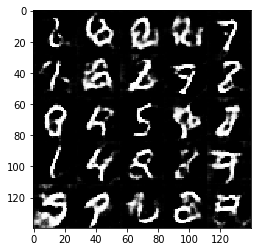

Epoch 0/2... Discriminator Loss: 0.9168... Generator Loss: 2.1175
Epoch 0/2... Discriminator Loss: 0.6950... Generator Loss: 1.1220
Epoch 0/2... Discriminator Loss: 0.7126... Generator Loss: 1.6889
Epoch 0/2... Discriminator Loss: 0.7086... Generator Loss: 1.3019
Epoch 0/2... Discriminator Loss: 0.5643... Generator Loss: 1.5846


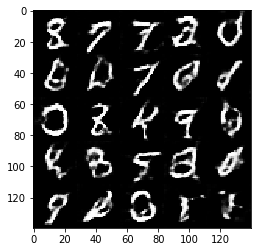

Epoch 0/2... Discriminator Loss: 0.7641... Generator Loss: 1.3436
Epoch 0/2... Discriminator Loss: 0.7682... Generator Loss: 1.2024
Epoch 0/2... Discriminator Loss: 1.0255... Generator Loss: 1.2661
Epoch 0/2... Discriminator Loss: 1.7806... Generator Loss: 0.2978
Epoch 0/2... Discriminator Loss: 0.9486... Generator Loss: 0.9159


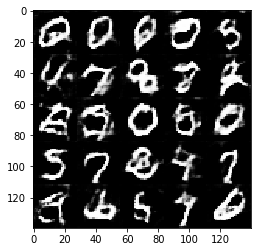

Epoch 0/2... Discriminator Loss: 0.9682... Generator Loss: 0.7408
Epoch 0/2... Discriminator Loss: 0.7925... Generator Loss: 0.9049
Epoch 0/2... Discriminator Loss: 0.8336... Generator Loss: 1.2440
Epoch 0/2... Discriminator Loss: 1.7011... Generator Loss: 0.4174
Epoch 0/2... Discriminator Loss: 0.7315... Generator Loss: 1.0395


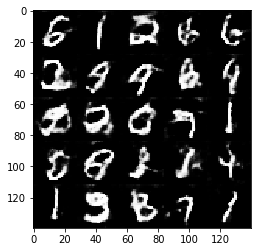

Epoch 0/2... Discriminator Loss: 0.9410... Generator Loss: 1.3381
Epoch 0/2... Discriminator Loss: 0.7875... Generator Loss: 1.7741
Epoch 0/2... Discriminator Loss: 2.4552... Generator Loss: 0.1277
Epoch 0/2... Discriminator Loss: 2.0594... Generator Loss: 0.2252
Epoch 0/2... Discriminator Loss: 0.9144... Generator Loss: 0.7609


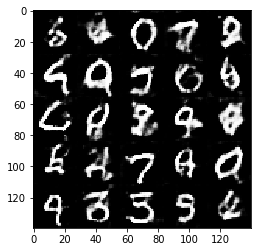

Epoch 0/2... Discriminator Loss: 1.7785... Generator Loss: 0.3686
Epoch 0/2... Discriminator Loss: 1.9450... Generator Loss: 0.2213
Epoch 0/2... Discriminator Loss: 0.8204... Generator Loss: 1.0237
Epoch 0/2... Discriminator Loss: 0.7214... Generator Loss: 1.1546
Epoch 0/2... Discriminator Loss: 0.9883... Generator Loss: 0.9337


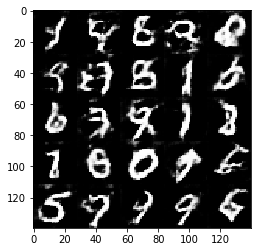

Epoch 0/2... Discriminator Loss: 3.5531... Generator Loss: 0.0630
Epoch 0/2... Discriminator Loss: 0.9528... Generator Loss: 0.7768
Epoch 0/2... Discriminator Loss: 0.6699... Generator Loss: 1.8513
Epoch 0/2... Discriminator Loss: 0.8306... Generator Loss: 1.7839
Epoch 0/2... Discriminator Loss: 0.5702... Generator Loss: 1.8607


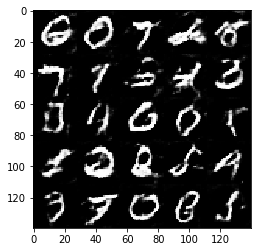

Epoch 0/2... Discriminator Loss: 1.6653... Generator Loss: 0.3823
Epoch 0/2... Discriminator Loss: 0.6659... Generator Loss: 1.0749
Epoch 0/2... Discriminator Loss: 0.9532... Generator Loss: 0.7796
Epoch 0/2... Discriminator Loss: 0.6825... Generator Loss: 1.2735
Epoch 0/2... Discriminator Loss: 1.1678... Generator Loss: 0.5685


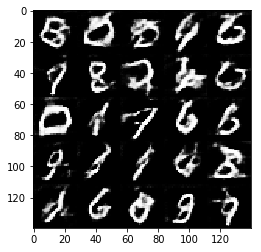

Epoch 0/2... Discriminator Loss: 0.8299... Generator Loss: 1.0466
Epoch 0/2... Discriminator Loss: 2.5540... Generator Loss: 0.1661
Epoch 0/2... Discriminator Loss: 0.5592... Generator Loss: 1.8904
Epoch 0/2... Discriminator Loss: 0.8491... Generator Loss: 0.8409
Epoch 0/2... Discriminator Loss: 0.6112... Generator Loss: 2.6145


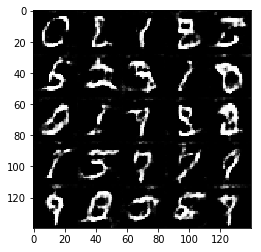

Epoch 0/2... Discriminator Loss: 0.7130... Generator Loss: 3.1125
Epoch 0/2... Discriminator Loss: 0.4843... Generator Loss: 1.8447
Epoch 0/2... Discriminator Loss: 0.8045... Generator Loss: 1.4945
Epoch 0/2... Discriminator Loss: 0.8863... Generator Loss: 2.5947
Epoch 0/2... Discriminator Loss: 0.5395... Generator Loss: 1.5148


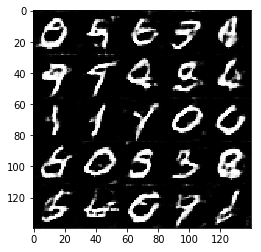

Epoch 0/2... Discriminator Loss: 0.9862... Generator Loss: 0.8033
Epoch 0/2... Discriminator Loss: 0.8745... Generator Loss: 1.8549
Epoch 0/2... Discriminator Loss: 0.4979... Generator Loss: 1.4109
Epoch 0/2... Discriminator Loss: 0.6371... Generator Loss: 1.3718
Epoch 0/2... Discriminator Loss: 0.8484... Generator Loss: 0.9615


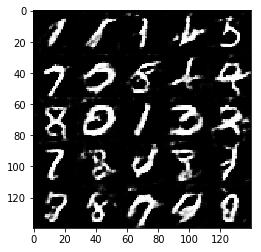

Epoch 0/2... Discriminator Loss: 0.6182... Generator Loss: 1.1620
Epoch 0/2... Discriminator Loss: 1.0547... Generator Loss: 4.1358
Epoch 0/2... Discriminator Loss: 0.6226... Generator Loss: 1.3044
Epoch 0/2... Discriminator Loss: 0.4419... Generator Loss: 2.5268
Epoch 0/2... Discriminator Loss: 2.0107... Generator Loss: 0.2075


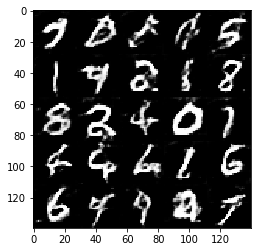

Epoch 0/2... Discriminator Loss: 0.6823... Generator Loss: 1.2255
Epoch 0/2... Discriminator Loss: 2.1546... Generator Loss: 0.2192
Epoch 0/2... Discriminator Loss: 0.9468... Generator Loss: 1.0296
Epoch 0/2... Discriminator Loss: 1.5098... Generator Loss: 0.4461
Epoch 0/2... Discriminator Loss: 0.8677... Generator Loss: 1.8496


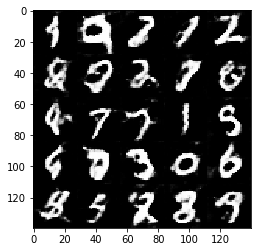

Epoch 0/2... Discriminator Loss: 0.9157... Generator Loss: 0.7875
Epoch 0/2... Discriminator Loss: 0.8740... Generator Loss: 0.8032
Epoch 0/2... Discriminator Loss: 0.3310... Generator Loss: 3.0591
Epoch 0/2... Discriminator Loss: 0.7617... Generator Loss: 1.0028
Epoch 0/2... Discriminator Loss: 1.2184... Generator Loss: 0.6369


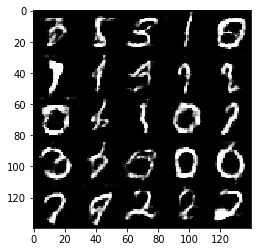

Epoch 0/2... Discriminator Loss: 0.8484... Generator Loss: 0.8260
Epoch 0/2... Discriminator Loss: 0.6970... Generator Loss: 1.8987
Epoch 0/2... Discriminator Loss: 0.6862... Generator Loss: 1.6058
Epoch 0/2... Discriminator Loss: 0.7466... Generator Loss: 2.1447
Epoch 0/2... Discriminator Loss: 1.5172... Generator Loss: 0.3509


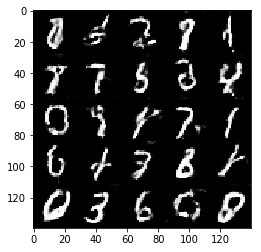

Epoch 0/2... Discriminator Loss: 0.9514... Generator Loss: 0.7525
Epoch 0/2... Discriminator Loss: 3.0290... Generator Loss: 0.1150
Epoch 0/2... Discriminator Loss: 1.6164... Generator Loss: 0.4473
Epoch 1/2... Discriminator Loss: 0.5459... Generator Loss: 2.0382
Epoch 1/2... Discriminator Loss: 2.4096... Generator Loss: 0.1972


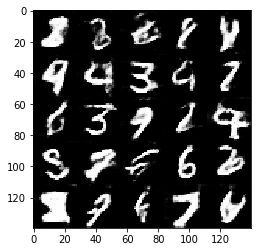

Epoch 1/2... Discriminator Loss: 0.4625... Generator Loss: 1.9089
Epoch 1/2... Discriminator Loss: 1.1288... Generator Loss: 1.7110
Epoch 1/2... Discriminator Loss: 0.8519... Generator Loss: 0.8262
Epoch 1/2... Discriminator Loss: 1.1620... Generator Loss: 0.6793
Epoch 1/2... Discriminator Loss: 0.4764... Generator Loss: 1.7661


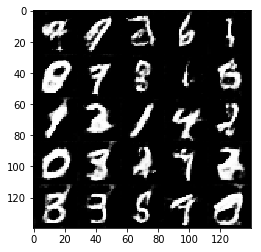

Epoch 1/2... Discriminator Loss: 0.8584... Generator Loss: 0.8293
Epoch 1/2... Discriminator Loss: 0.7210... Generator Loss: 1.2016
Epoch 1/2... Discriminator Loss: 0.6635... Generator Loss: 1.3482
Epoch 1/2... Discriminator Loss: 2.2023... Generator Loss: 6.7169
Epoch 1/2... Discriminator Loss: 1.0709... Generator Loss: 0.7500


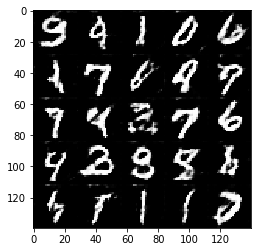

Epoch 1/2... Discriminator Loss: 1.5615... Generator Loss: 4.5439
Epoch 1/2... Discriminator Loss: 0.6760... Generator Loss: 1.8628
Epoch 1/2... Discriminator Loss: 0.7564... Generator Loss: 1.0596
Epoch 1/2... Discriminator Loss: 1.8544... Generator Loss: 0.3018
Epoch 1/2... Discriminator Loss: 0.9247... Generator Loss: 1.0061


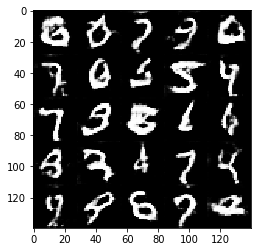

Epoch 1/2... Discriminator Loss: 2.5588... Generator Loss: 4.8338
Epoch 1/2... Discriminator Loss: 0.9063... Generator Loss: 1.2218
Epoch 1/2... Discriminator Loss: 0.9254... Generator Loss: 1.6497
Epoch 1/2... Discriminator Loss: 1.0265... Generator Loss: 0.7731
Epoch 1/2... Discriminator Loss: 1.0306... Generator Loss: 0.6988


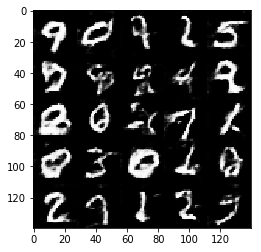

Epoch 1/2... Discriminator Loss: 0.7622... Generator Loss: 0.9804
Epoch 1/2... Discriminator Loss: 0.8548... Generator Loss: 0.8241
Epoch 1/2... Discriminator Loss: 0.4416... Generator Loss: 2.9032
Epoch 1/2... Discriminator Loss: 0.9207... Generator Loss: 0.8728
Epoch 1/2... Discriminator Loss: 0.7163... Generator Loss: 1.1194


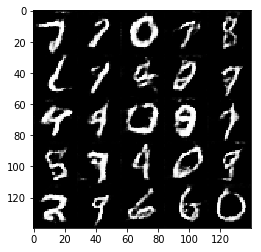

Epoch 1/2... Discriminator Loss: 0.7027... Generator Loss: 1.3729
Epoch 1/2... Discriminator Loss: 4.0124... Generator Loss: 0.0492
Epoch 1/2... Discriminator Loss: 1.3664... Generator Loss: 0.5364
Epoch 1/2... Discriminator Loss: 0.7912... Generator Loss: 1.1370
Epoch 1/2... Discriminator Loss: 0.8314... Generator Loss: 0.9026


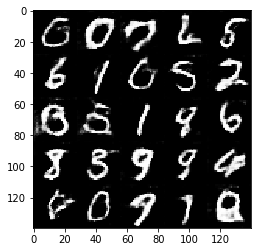

Epoch 1/2... Discriminator Loss: 0.5888... Generator Loss: 1.3425
Epoch 1/2... Discriminator Loss: 0.7114... Generator Loss: 1.5386
Epoch 1/2... Discriminator Loss: 0.4274... Generator Loss: 1.6866
Epoch 1/2... Discriminator Loss: 3.0217... Generator Loss: 5.8920
Epoch 1/2... Discriminator Loss: 0.6020... Generator Loss: 1.4120


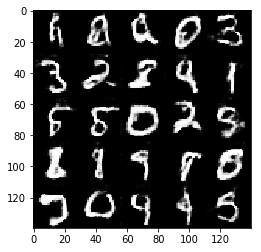

Epoch 1/2... Discriminator Loss: 0.8783... Generator Loss: 1.9641
Epoch 1/2... Discriminator Loss: 1.1849... Generator Loss: 0.5910
Epoch 1/2... Discriminator Loss: 0.9197... Generator Loss: 1.5286
Epoch 1/2... Discriminator Loss: 1.7429... Generator Loss: 0.3264
Epoch 1/2... Discriminator Loss: 2.4834... Generator Loss: 0.2544


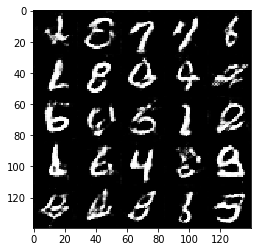

Epoch 1/2... Discriminator Loss: 0.5072... Generator Loss: 3.6760
Epoch 1/2... Discriminator Loss: 0.5375... Generator Loss: 1.6639
Epoch 1/2... Discriminator Loss: 1.9759... Generator Loss: 0.2649
Epoch 1/2... Discriminator Loss: 0.9353... Generator Loss: 0.8404
Epoch 1/2... Discriminator Loss: 0.9586... Generator Loss: 1.0528


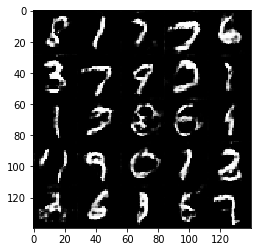

Epoch 1/2... Discriminator Loss: 0.4486... Generator Loss: 1.4235
Epoch 1/2... Discriminator Loss: 1.1689... Generator Loss: 0.7775
Epoch 1/2... Discriminator Loss: 0.6488... Generator Loss: 1.1144
Epoch 1/2... Discriminator Loss: 2.5541... Generator Loss: 0.1564
Epoch 1/2... Discriminator Loss: 0.9159... Generator Loss: 0.8272


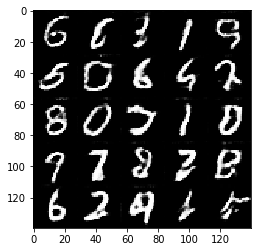

Epoch 1/2... Discriminator Loss: 0.6241... Generator Loss: 1.0572
Epoch 1/2... Discriminator Loss: 0.3057... Generator Loss: 2.0815
Epoch 1/2... Discriminator Loss: 1.0308... Generator Loss: 0.6998
Epoch 1/2... Discriminator Loss: 1.0085... Generator Loss: 0.6635
Epoch 1/2... Discriminator Loss: 1.7452... Generator Loss: 0.3592


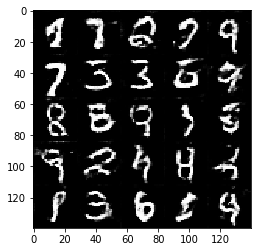

Epoch 1/2... Discriminator Loss: 1.6690... Generator Loss: 0.6206
Epoch 1/2... Discriminator Loss: 1.8964... Generator Loss: 0.6024
Epoch 1/2... Discriminator Loss: 0.9660... Generator Loss: 0.9050
Epoch 1/2... Discriminator Loss: 0.8147... Generator Loss: 2.3110
Epoch 1/2... Discriminator Loss: 1.1458... Generator Loss: 3.2250


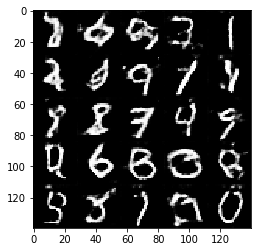

Epoch 1/2... Discriminator Loss: 0.7986... Generator Loss: 1.3111
Epoch 1/2... Discriminator Loss: 0.7040... Generator Loss: 1.5149
Epoch 1/2... Discriminator Loss: 0.7797... Generator Loss: 1.2902
Epoch 1/2... Discriminator Loss: 0.9287... Generator Loss: 0.8978
Epoch 1/2... Discriminator Loss: 0.6752... Generator Loss: 1.9988


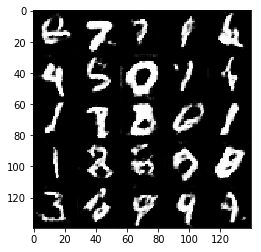

Epoch 1/2... Discriminator Loss: 0.3454... Generator Loss: 2.0391
Epoch 1/2... Discriminator Loss: 1.1417... Generator Loss: 0.6501
Epoch 1/2... Discriminator Loss: 0.7515... Generator Loss: 0.8868
Epoch 1/2... Discriminator Loss: 1.9575... Generator Loss: 0.2739
Epoch 1/2... Discriminator Loss: 0.9670... Generator Loss: 0.9124


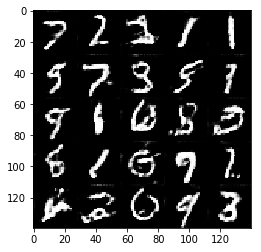

Epoch 1/2... Discriminator Loss: 1.8263... Generator Loss: 0.4364
Epoch 1/2... Discriminator Loss: 2.5968... Generator Loss: 0.1914
Epoch 1/2... Discriminator Loss: 2.3052... Generator Loss: 0.3646
Epoch 1/2... Discriminator Loss: 1.0117... Generator Loss: 0.6894
Epoch 1/2... Discriminator Loss: 1.5991... Generator Loss: 0.6060


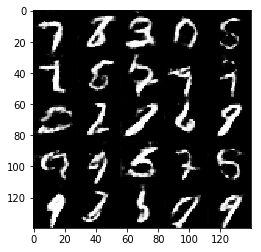

Epoch 1/2... Discriminator Loss: 0.6103... Generator Loss: 1.5373
Epoch 1/2... Discriminator Loss: 0.6112... Generator Loss: 2.0677
Epoch 1/2... Discriminator Loss: 0.9791... Generator Loss: 0.7659
Epoch 1/2... Discriminator Loss: 0.4336... Generator Loss: 2.0107
Epoch 1/2... Discriminator Loss: 0.9647... Generator Loss: 0.7796


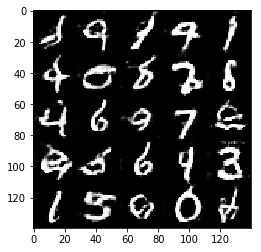

Epoch 1/2... Discriminator Loss: 2.4246... Generator Loss: 0.1675
Epoch 1/2... Discriminator Loss: 0.7070... Generator Loss: 1.4205
Epoch 1/2... Discriminator Loss: 2.7438... Generator Loss: 0.1826
Epoch 1/2... Discriminator Loss: 1.6080... Generator Loss: 0.9057
Epoch 1/2... Discriminator Loss: 0.3307... Generator Loss: 2.3925


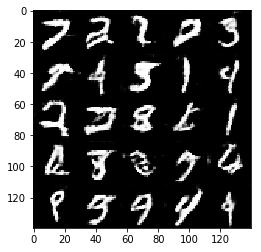

Epoch 1/2... Discriminator Loss: 0.3438... Generator Loss: 1.9720
Epoch 1/2... Discriminator Loss: 0.5738... Generator Loss: 1.7323
Epoch 1/2... Discriminator Loss: 0.8562... Generator Loss: 1.1035
Epoch 1/2... Discriminator Loss: 0.9268... Generator Loss: 0.7866
Epoch 1/2... Discriminator Loss: 1.0868... Generator Loss: 0.7725


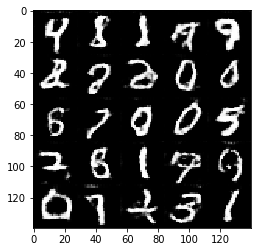

Epoch 1/2... Discriminator Loss: 1.7990... Generator Loss: 0.4523
Epoch 1/2... Discriminator Loss: 0.6119... Generator Loss: 1.2386
Epoch 1/2... Discriminator Loss: 0.6763... Generator Loss: 1.2139
Epoch 1/2... Discriminator Loss: 1.6606... Generator Loss: 0.4992
Epoch 1/2... Discriminator Loss: 3.0199... Generator Loss: 0.2141


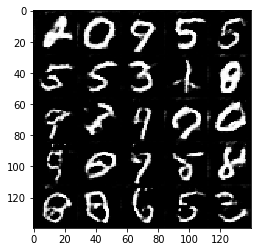

Epoch 1/2... Discriminator Loss: 1.7288... Generator Loss: 0.3788
Epoch 1/2... Discriminator Loss: 0.6208... Generator Loss: 1.4906
Epoch 1/2... Discriminator Loss: 0.6151... Generator Loss: 1.2699
Epoch 1/2... Discriminator Loss: 0.7772... Generator Loss: 0.8683
Epoch 1/2... Discriminator Loss: 0.6524... Generator Loss: 1.3972


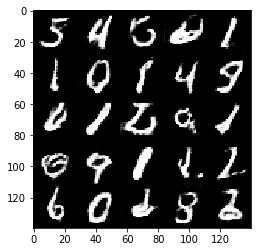

Epoch 1/2... Discriminator Loss: 0.9799... Generator Loss: 3.6682
Epoch 1/2... Discriminator Loss: 0.7850... Generator Loss: 1.0492
Epoch 1/2... Discriminator Loss: 1.0831... Generator Loss: 0.7089
Epoch 1/2... Discriminator Loss: 0.6007... Generator Loss: 1.2755
Epoch 1/2... Discriminator Loss: 1.6677... Generator Loss: 0.4147


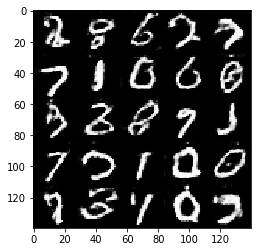

Epoch 1/2... Discriminator Loss: 0.3870... Generator Loss: 2.1111
Epoch 1/2... Discriminator Loss: 0.6763... Generator Loss: 1.2630
Epoch 1/2... Discriminator Loss: 0.9715... Generator Loss: 0.7351
Epoch 1/2... Discriminator Loss: 1.6518... Generator Loss: 0.4826
Epoch 1/2... Discriminator Loss: 0.5835... Generator Loss: 1.2907


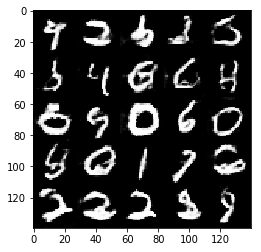

Epoch 1/2... Discriminator Loss: 0.6622... Generator Loss: 1.6267
Epoch 1/2... Discriminator Loss: 1.3203... Generator Loss: 0.4910
Epoch 1/2... Discriminator Loss: 0.2316... Generator Loss: 2.8322
Epoch 1/2... Discriminator Loss: 0.3680... Generator Loss: 2.0358
Epoch 1/2... Discriminator Loss: 3.5442... Generator Loss: 0.0883


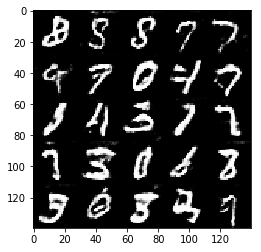

Epoch 1/2... Discriminator Loss: 1.9723... Generator Loss: 0.4077
Epoch 1/2... Discriminator Loss: 0.5347... Generator Loss: 1.7564
Epoch 1/2... Discriminator Loss: 1.2384... Generator Loss: 0.5037
Epoch 1/2... Discriminator Loss: 0.5915... Generator Loss: 1.4308
Epoch 1/2... Discriminator Loss: 2.8195... Generator Loss: 0.3863


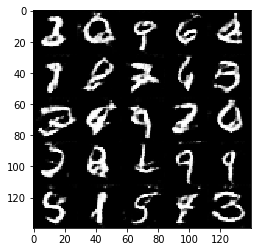

Epoch 1/2... Discriminator Loss: 1.1790... Generator Loss: 0.5996
Epoch 1/2... Discriminator Loss: 0.3971... Generator Loss: 1.6007
Epoch 1/2... Discriminator Loss: 1.4193... Generator Loss: 0.5390
Epoch 1/2... Discriminator Loss: 1.1594... Generator Loss: 0.7240
Epoch 1/2... Discriminator Loss: 1.2728... Generator Loss: 0.6446


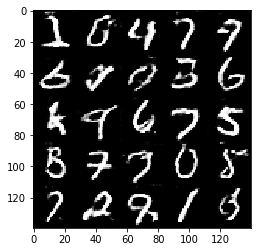

Epoch 1/2... Discriminator Loss: 0.5197... Generator Loss: 2.5137
Epoch 1/2... Discriminator Loss: 0.5468... Generator Loss: 1.5799
Epoch 1/2... Discriminator Loss: 1.3245... Generator Loss: 0.5409
Epoch 1/2... Discriminator Loss: 0.7624... Generator Loss: 1.2776
Epoch 1/2... Discriminator Loss: 0.5464... Generator Loss: 1.6311


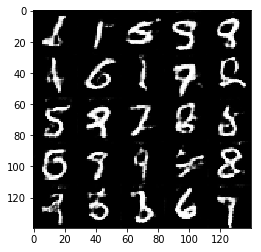

Epoch 1/2... Discriminator Loss: 0.6408... Generator Loss: 1.0963
Epoch 1/2... Discriminator Loss: 0.6631... Generator Loss: 1.1781
Epoch 1/2... Discriminator Loss: 1.1100... Generator Loss: 0.6909
Epoch 1/2... Discriminator Loss: 1.0535... Generator Loss: 0.6621
Epoch 1/2... Discriminator Loss: 0.6309... Generator Loss: 1.4334


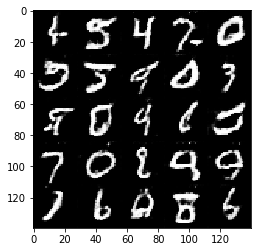

Epoch 1/2... Discriminator Loss: 0.8714... Generator Loss: 0.8710
Epoch 1/2... Discriminator Loss: 0.6983... Generator Loss: 1.3444
Epoch 1/2... Discriminator Loss: 0.6006... Generator Loss: 1.8159
Epoch 1/2... Discriminator Loss: 2.5156... Generator Loss: 0.2098
Epoch 1/2... Discriminator Loss: 1.9442... Generator Loss: 0.4025


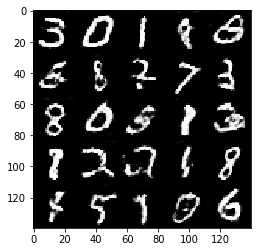

Epoch 1/2... Discriminator Loss: 0.6413... Generator Loss: 1.6492
Epoch 1/2... Discriminator Loss: 0.6281... Generator Loss: 1.4846
Epoch 1/2... Discriminator Loss: 0.3329... Generator Loss: 2.1775
Epoch 1/2... Discriminator Loss: 1.1361... Generator Loss: 5.2075
Epoch 1/2... Discriminator Loss: 0.8710... Generator Loss: 0.8009


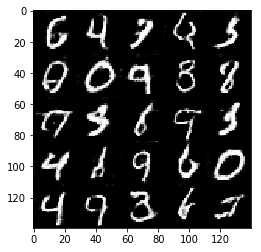

Epoch 1/2... Discriminator Loss: 0.4274... Generator Loss: 2.0350
Epoch 1/2... Discriminator Loss: 0.7856... Generator Loss: 0.8107
Epoch 1/2... Discriminator Loss: 1.7720... Generator Loss: 0.5297
Epoch 1/2... Discriminator Loss: 1.2443... Generator Loss: 0.6317
Epoch 1/2... Discriminator Loss: 0.3789... Generator Loss: 2.4546


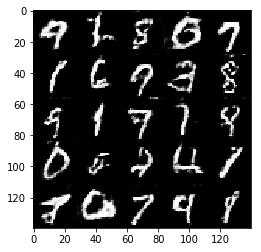

Epoch 1/2... Discriminator Loss: 3.3669... Generator Loss: 0.0801
Epoch 1/2... Discriminator Loss: 2.0582... Generator Loss: 0.3586
Epoch 1/2... Discriminator Loss: 0.2714... Generator Loss: 2.5134
Epoch 1/2... Discriminator Loss: 2.0687... Generator Loss: 0.3024
Epoch 1/2... Discriminator Loss: 1.0045... Generator Loss: 0.7693


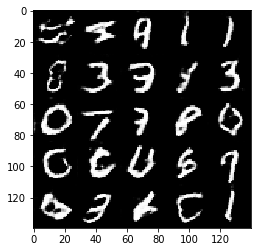

Epoch 1/2... Discriminator Loss: 0.6306... Generator Loss: 1.4175
Epoch 1/2... Discriminator Loss: 0.4357... Generator Loss: 6.6174
Epoch 1/2... Discriminator Loss: 0.4874... Generator Loss: 1.5236
Epoch 1/2... Discriminator Loss: 0.3237... Generator Loss: 2.1130
Epoch 1/2... Discriminator Loss: 0.7310... Generator Loss: 2.4964


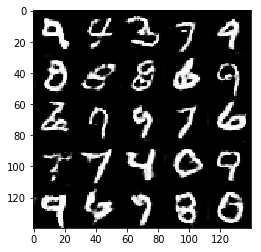

Epoch 1/2... Discriminator Loss: 0.4152... Generator Loss: 1.6637
Epoch 1/2... Discriminator Loss: 2.7952... Generator Loss: 0.2556
Epoch 1/2... Discriminator Loss: 0.8238... Generator Loss: 1.1474
Epoch 1/2... Discriminator Loss: 0.9988... Generator Loss: 1.0789
Epoch 1/2... Discriminator Loss: 1.1436... Generator Loss: 0.6916


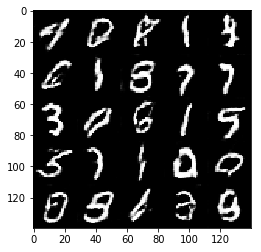

Epoch 1/2... Discriminator Loss: 0.7909... Generator Loss: 0.8766
Epoch 1/2... Discriminator Loss: 1.3964... Generator Loss: 0.6166
Epoch 1/2... Discriminator Loss: 2.2541... Generator Loss: 0.2853
Epoch 1/2... Discriminator Loss: 1.1936... Generator Loss: 0.7573
Epoch 1/2... Discriminator Loss: 0.4102... Generator Loss: 4.8814


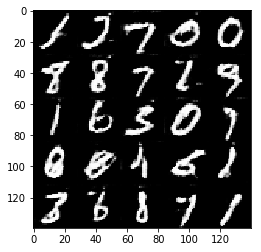

Epoch 1/2... Discriminator Loss: 0.4555... Generator Loss: 1.8539
Epoch 1/2... Discriminator Loss: 0.5164... Generator Loss: 1.7183
Epoch 1/2... Discriminator Loss: 0.8294... Generator Loss: 0.9513
Epoch 1/2... Discriminator Loss: 0.6747... Generator Loss: 1.1768
Epoch 1/2... Discriminator Loss: 1.1931... Generator Loss: 0.5687


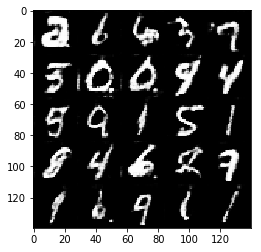

Epoch 1/2... Discriminator Loss: 0.6971... Generator Loss: 1.0108
Epoch 1/2... Discriminator Loss: 2.0714... Generator Loss: 0.2417
Epoch 1/2... Discriminator Loss: 0.6274... Generator Loss: 1.2823
Epoch 1/2... Discriminator Loss: 0.6675... Generator Loss: 1.8227
Epoch 1/2... Discriminator Loss: 0.9426... Generator Loss: 1.4983


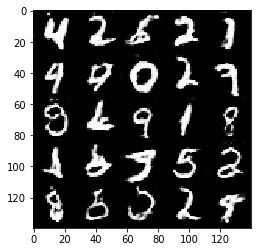

Epoch 1/2... Discriminator Loss: 0.8478... Generator Loss: 1.0233
Epoch 1/2... Discriminator Loss: 1.4849... Generator Loss: 6.4129
Epoch 1/2... Discriminator Loss: 0.8119... Generator Loss: 1.0685
Epoch 1/2... Discriminator Loss: 0.7504... Generator Loss: 0.9116
Epoch 1/2... Discriminator Loss: 0.6171... Generator Loss: 1.1170


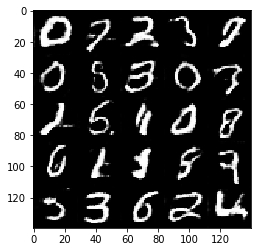

Epoch 1/2... Discriminator Loss: 0.4265... Generator Loss: 1.7705


In [21]:
batch_size = 32
z_dim = 100
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 0/1... Discriminator Loss: 0.0268... Generator Loss: 36.5181
Epoch 0/1... Discriminator Loss: 2.4749... Generator Loss: 8.9681
Epoch 0/1... Discriminator Loss: 0.4260... Generator Loss: 3.6487
Epoch 0/1... Discriminator Loss: 9.2303... Generator Loss: 0.6122


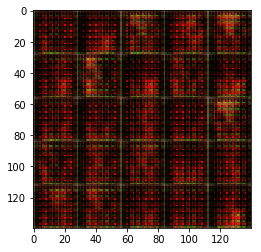

Epoch 0/1... Discriminator Loss: 6.3848... Generator Loss: 18.6556
Epoch 0/1... Discriminator Loss: 0.5659... Generator Loss: 1.6116
Epoch 0/1... Discriminator Loss: 0.3187... Generator Loss: 10.5954
Epoch 0/1... Discriminator Loss: 0.0596... Generator Loss: 21.0257
Epoch 0/1... Discriminator Loss: 0.3024... Generator Loss: 6.4516


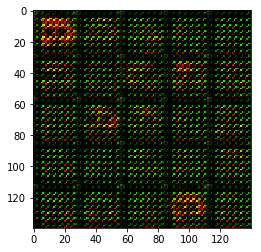

Epoch 0/1... Discriminator Loss: 5.1389... Generator Loss: 0.4010
Epoch 0/1... Discriminator Loss: 0.2979... Generator Loss: 11.6109
Epoch 0/1... Discriminator Loss: 0.3161... Generator Loss: 12.8419
Epoch 0/1... Discriminator Loss: 0.7118... Generator Loss: 4.1189
Epoch 0/1... Discriminator Loss: 0.7687... Generator Loss: 3.6929


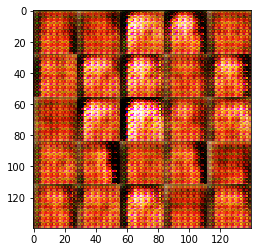

Epoch 0/1... Discriminator Loss: 1.2508... Generator Loss: 6.0114
Epoch 0/1... Discriminator Loss: 6.3284... Generator Loss: 0.0296
Epoch 0/1... Discriminator Loss: 2.3232... Generator Loss: 9.0698
Epoch 0/1... Discriminator Loss: 0.7109... Generator Loss: 1.3866
Epoch 0/1... Discriminator Loss: 1.5071... Generator Loss: 0.5230


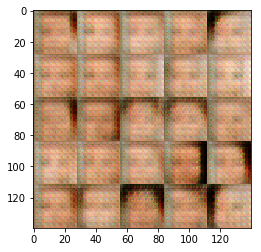

Epoch 0/1... Discriminator Loss: 0.8985... Generator Loss: 1.5575
Epoch 0/1... Discriminator Loss: 1.0639... Generator Loss: 1.1914
Epoch 0/1... Discriminator Loss: 0.9818... Generator Loss: 1.6170
Epoch 0/1... Discriminator Loss: 2.4790... Generator Loss: 0.1512
Epoch 0/1... Discriminator Loss: 0.7835... Generator Loss: 0.8349


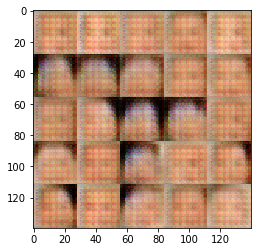

Epoch 0/1... Discriminator Loss: 2.3264... Generator Loss: 4.6961
Epoch 0/1... Discriminator Loss: 0.7290... Generator Loss: 8.1924
Epoch 0/1... Discriminator Loss: 1.3972... Generator Loss: 0.6176
Epoch 0/1... Discriminator Loss: 1.0703... Generator Loss: 0.7013
Epoch 0/1... Discriminator Loss: 1.3701... Generator Loss: 0.4051


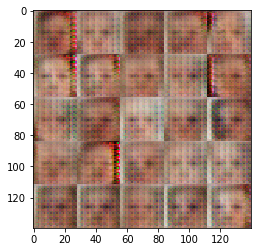

Epoch 0/1... Discriminator Loss: 1.4801... Generator Loss: 5.4124
Epoch 0/1... Discriminator Loss: 0.8337... Generator Loss: 2.0593
Epoch 0/1... Discriminator Loss: 0.8540... Generator Loss: 0.8836
Epoch 0/1... Discriminator Loss: 3.1040... Generator Loss: 0.0916
Epoch 0/1... Discriminator Loss: 0.4527... Generator Loss: 1.8531


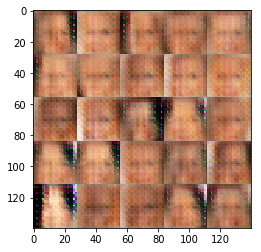

Epoch 0/1... Discriminator Loss: 2.1331... Generator Loss: 0.1807
Epoch 0/1... Discriminator Loss: 2.1985... Generator Loss: 0.1965
Epoch 0/1... Discriminator Loss: 1.0605... Generator Loss: 1.1854
Epoch 0/1... Discriminator Loss: 0.9109... Generator Loss: 1.1303
Epoch 0/1... Discriminator Loss: 3.7170... Generator Loss: 0.1267


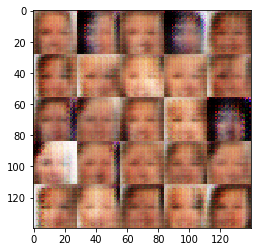

Epoch 0/1... Discriminator Loss: 0.9772... Generator Loss: 0.8003
Epoch 0/1... Discriminator Loss: 1.5242... Generator Loss: 3.8872
Epoch 0/1... Discriminator Loss: 1.4689... Generator Loss: 3.6265
Epoch 0/1... Discriminator Loss: 0.7637... Generator Loss: 2.0559
Epoch 0/1... Discriminator Loss: 1.3045... Generator Loss: 0.4724


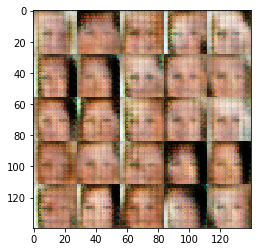

Epoch 0/1... Discriminator Loss: 3.3457... Generator Loss: 0.0550
Epoch 0/1... Discriminator Loss: 0.6895... Generator Loss: 1.0935
Epoch 0/1... Discriminator Loss: 0.2361... Generator Loss: 2.4183
Epoch 0/1... Discriminator Loss: 0.7929... Generator Loss: 1.1424
Epoch 0/1... Discriminator Loss: 1.9020... Generator Loss: 5.9536


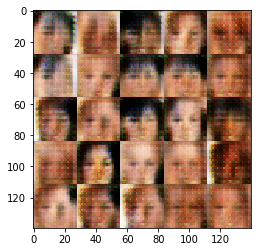

Epoch 0/1... Discriminator Loss: 0.7887... Generator Loss: 3.2308
Epoch 0/1... Discriminator Loss: 0.7986... Generator Loss: 0.8605
Epoch 0/1... Discriminator Loss: 0.7096... Generator Loss: 1.3492
Epoch 0/1... Discriminator Loss: 1.5730... Generator Loss: 0.2913
Epoch 0/1... Discriminator Loss: 0.8943... Generator Loss: 0.9323


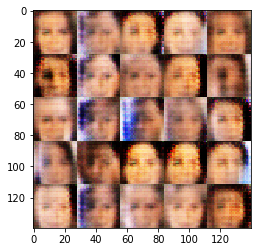

Epoch 0/1... Discriminator Loss: 0.9087... Generator Loss: 0.7367
Epoch 0/1... Discriminator Loss: 0.6029... Generator Loss: 1.1390
Epoch 0/1... Discriminator Loss: 0.8652... Generator Loss: 0.8662
Epoch 0/1... Discriminator Loss: 0.6113... Generator Loss: 1.3718
Epoch 0/1... Discriminator Loss: 0.8509... Generator Loss: 0.9422


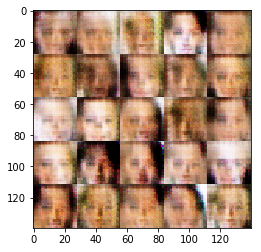

Epoch 0/1... Discriminator Loss: 1.8448... Generator Loss: 4.7222
Epoch 0/1... Discriminator Loss: 1.3974... Generator Loss: 0.4429
Epoch 0/1... Discriminator Loss: 0.5738... Generator Loss: 1.4087
Epoch 0/1... Discriminator Loss: 1.9256... Generator Loss: 4.2617
Epoch 0/1... Discriminator Loss: 0.8219... Generator Loss: 0.8830


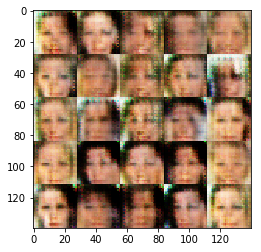

Epoch 0/1... Discriminator Loss: 0.7836... Generator Loss: 1.0859
Epoch 0/1... Discriminator Loss: 1.3586... Generator Loss: 0.5142
Epoch 0/1... Discriminator Loss: 2.0612... Generator Loss: 4.9037
Epoch 0/1... Discriminator Loss: 0.5818... Generator Loss: 1.6630
Epoch 0/1... Discriminator Loss: 0.8066... Generator Loss: 0.8842


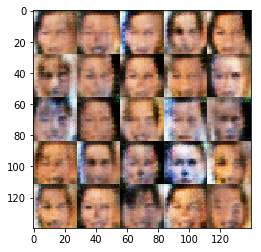

Epoch 0/1... Discriminator Loss: 0.8093... Generator Loss: 1.0432
Epoch 0/1... Discriminator Loss: 0.4643... Generator Loss: 1.8639
Epoch 0/1... Discriminator Loss: 0.4790... Generator Loss: 1.4799
Epoch 0/1... Discriminator Loss: 0.7604... Generator Loss: 1.4437
Epoch 0/1... Discriminator Loss: 0.8253... Generator Loss: 0.9805


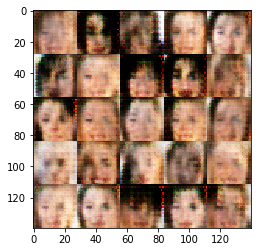

Epoch 0/1... Discriminator Loss: 1.6480... Generator Loss: 0.3335
Epoch 0/1... Discriminator Loss: 0.6216... Generator Loss: 1.0957
Epoch 0/1... Discriminator Loss: 0.5883... Generator Loss: 4.1950
Epoch 0/1... Discriminator Loss: 0.4330... Generator Loss: 2.1799
Epoch 0/1... Discriminator Loss: 0.8494... Generator Loss: 0.8038


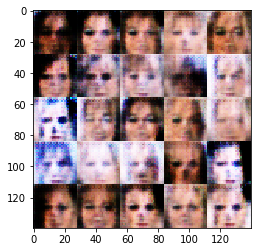

Epoch 0/1... Discriminator Loss: 0.7212... Generator Loss: 2.9392
Epoch 0/1... Discriminator Loss: 0.6779... Generator Loss: 1.1654
Epoch 0/1... Discriminator Loss: 0.5407... Generator Loss: 1.4688
Epoch 0/1... Discriminator Loss: 0.8190... Generator Loss: 2.2297
Epoch 0/1... Discriminator Loss: 0.7529... Generator Loss: 0.8293


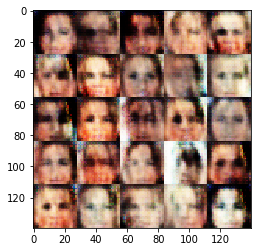

Epoch 0/1... Discriminator Loss: 1.0608... Generator Loss: 3.3957
Epoch 0/1... Discriminator Loss: 0.6324... Generator Loss: 2.5865
Epoch 0/1... Discriminator Loss: 0.9076... Generator Loss: 2.7204
Epoch 0/1... Discriminator Loss: 0.4123... Generator Loss: 2.1834
Epoch 0/1... Discriminator Loss: 0.5456... Generator Loss: 1.2065


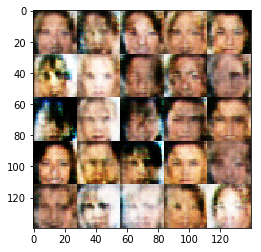

Epoch 0/1... Discriminator Loss: 1.6075... Generator Loss: 0.4767
Epoch 0/1... Discriminator Loss: 0.9998... Generator Loss: 0.7600
Epoch 0/1... Discriminator Loss: 0.6307... Generator Loss: 1.9877
Epoch 0/1... Discriminator Loss: 0.5864... Generator Loss: 1.2545
Epoch 0/1... Discriminator Loss: 1.0664... Generator Loss: 2.5482


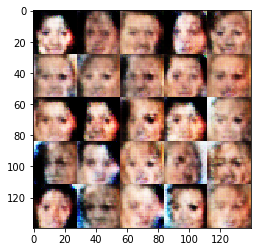

Epoch 0/1... Discriminator Loss: 0.5022... Generator Loss: 1.4102
Epoch 0/1... Discriminator Loss: 1.3275... Generator Loss: 0.5087
Epoch 0/1... Discriminator Loss: 1.0141... Generator Loss: 0.8534
Epoch 0/1... Discriminator Loss: 0.7341... Generator Loss: 1.4558
Epoch 0/1... Discriminator Loss: 0.6324... Generator Loss: 1.2916


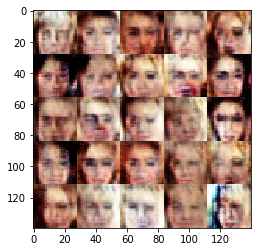

Epoch 0/1... Discriminator Loss: 0.5352... Generator Loss: 1.2459
Epoch 0/1... Discriminator Loss: 0.8521... Generator Loss: 3.2686
Epoch 0/1... Discriminator Loss: 2.7396... Generator Loss: 6.5843
Epoch 0/1... Discriminator Loss: 0.7136... Generator Loss: 0.9858
Epoch 0/1... Discriminator Loss: 0.8892... Generator Loss: 1.1066


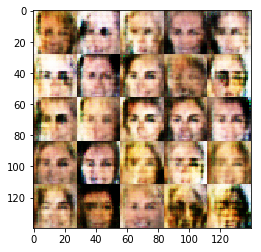

Epoch 0/1... Discriminator Loss: 0.7149... Generator Loss: 1.1648
Epoch 0/1... Discriminator Loss: 0.9071... Generator Loss: 2.3973
Epoch 0/1... Discriminator Loss: 0.3246... Generator Loss: 1.8967
Epoch 0/1... Discriminator Loss: 0.6359... Generator Loss: 1.2966
Epoch 0/1... Discriminator Loss: 2.0032... Generator Loss: 3.1970


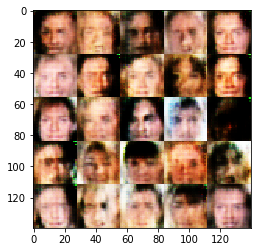

Epoch 0/1... Discriminator Loss: 0.3965... Generator Loss: 1.7898
Epoch 0/1... Discriminator Loss: 0.5338... Generator Loss: 2.1253
Epoch 0/1... Discriminator Loss: 0.8487... Generator Loss: 1.8513
Epoch 0/1... Discriminator Loss: 1.0409... Generator Loss: 0.6235
Epoch 0/1... Discriminator Loss: 0.4908... Generator Loss: 1.4213


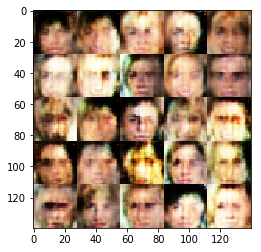

Epoch 0/1... Discriminator Loss: 0.3444... Generator Loss: 3.1150
Epoch 0/1... Discriminator Loss: 0.8602... Generator Loss: 3.4611
Epoch 0/1... Discriminator Loss: 1.0243... Generator Loss: 0.6965
Epoch 0/1... Discriminator Loss: 0.8325... Generator Loss: 1.2874
Epoch 0/1... Discriminator Loss: 0.9154... Generator Loss: 0.7960


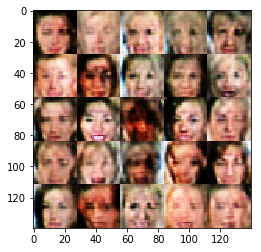

Epoch 0/1... Discriminator Loss: 0.6685... Generator Loss: 2.1813
Epoch 0/1... Discriminator Loss: 1.2542... Generator Loss: 0.4907
Epoch 0/1... Discriminator Loss: 1.0940... Generator Loss: 0.6546
Epoch 0/1... Discriminator Loss: 0.5641... Generator Loss: 1.4152
Epoch 0/1... Discriminator Loss: 1.5008... Generator Loss: 2.9272


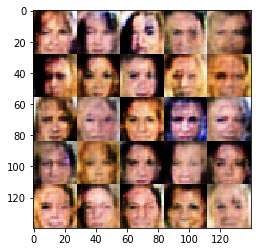

Epoch 0/1... Discriminator Loss: 0.5883... Generator Loss: 1.5956
Epoch 0/1... Discriminator Loss: 0.7698... Generator Loss: 1.1727
Epoch 0/1... Discriminator Loss: 0.9965... Generator Loss: 3.1389
Epoch 0/1... Discriminator Loss: 0.3426... Generator Loss: 1.7018
Epoch 0/1... Discriminator Loss: 1.0914... Generator Loss: 0.7840


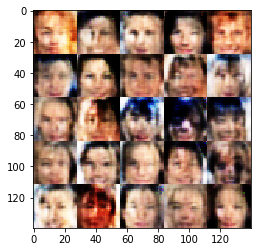

Epoch 0/1... Discriminator Loss: 0.3069... Generator Loss: 1.8913
Epoch 0/1... Discriminator Loss: 0.4651... Generator Loss: 2.1770
Epoch 0/1... Discriminator Loss: 0.3552... Generator Loss: 1.7362
Epoch 0/1... Discriminator Loss: 0.2455... Generator Loss: 3.0057
Epoch 0/1... Discriminator Loss: 0.1523... Generator Loss: 3.1752


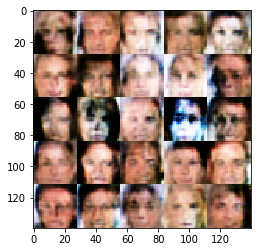

Epoch 0/1... Discriminator Loss: 0.9872... Generator Loss: 0.7641
Epoch 0/1... Discriminator Loss: 0.5049... Generator Loss: 1.3070
Epoch 0/1... Discriminator Loss: 0.7193... Generator Loss: 1.3032
Epoch 0/1... Discriminator Loss: 1.4178... Generator Loss: 0.4134
Epoch 0/1... Discriminator Loss: 0.8770... Generator Loss: 0.8183


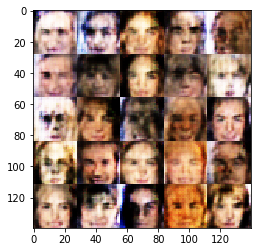

Epoch 0/1... Discriminator Loss: 0.5105... Generator Loss: 1.5545
Epoch 0/1... Discriminator Loss: 1.1214... Generator Loss: 0.5022
Epoch 0/1... Discriminator Loss: 0.6742... Generator Loss: 1.0130
Epoch 0/1... Discriminator Loss: 0.9766... Generator Loss: 0.7767
Epoch 0/1... Discriminator Loss: 1.2580... Generator Loss: 0.5184


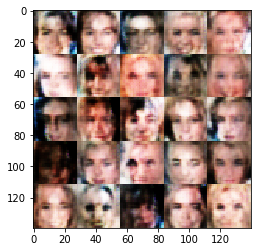

Epoch 0/1... Discriminator Loss: 0.5111... Generator Loss: 1.5403
Epoch 0/1... Discriminator Loss: 1.4637... Generator Loss: 0.3913
Epoch 0/1... Discriminator Loss: 0.4360... Generator Loss: 2.1462
Epoch 0/1... Discriminator Loss: 1.1167... Generator Loss: 1.0891
Epoch 0/1... Discriminator Loss: 0.6956... Generator Loss: 1.9928


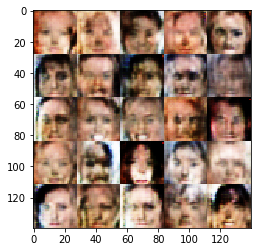

Epoch 0/1... Discriminator Loss: 0.5727... Generator Loss: 1.1483
Epoch 0/1... Discriminator Loss: 0.5879... Generator Loss: 1.1002
Epoch 0/1... Discriminator Loss: 0.8636... Generator Loss: 0.7939
Epoch 0/1... Discriminator Loss: 0.4283... Generator Loss: 1.4742
Epoch 0/1... Discriminator Loss: 0.9835... Generator Loss: 0.6743


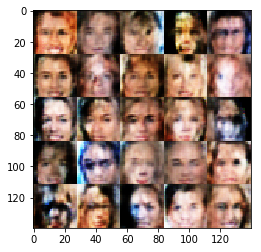

Epoch 0/1... Discriminator Loss: 0.7185... Generator Loss: 0.8883
Epoch 0/1... Discriminator Loss: 0.8074... Generator Loss: 0.7711
Epoch 0/1... Discriminator Loss: 1.0110... Generator Loss: 0.6801
Epoch 0/1... Discriminator Loss: 0.8334... Generator Loss: 0.9427
Epoch 0/1... Discriminator Loss: 0.6079... Generator Loss: 5.0278


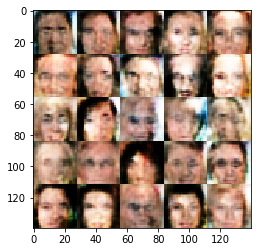

Epoch 0/1... Discriminator Loss: 0.3644... Generator Loss: 4.9290
Epoch 0/1... Discriminator Loss: 0.6144... Generator Loss: 2.3682
Epoch 0/1... Discriminator Loss: 0.2284... Generator Loss: 2.9962
Epoch 0/1... Discriminator Loss: 0.5411... Generator Loss: 1.2356
Epoch 0/1... Discriminator Loss: 0.7552... Generator Loss: 0.8269


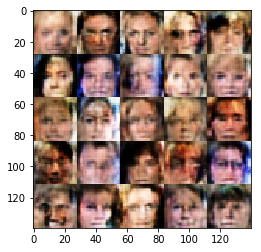

Epoch 0/1... Discriminator Loss: 0.5544... Generator Loss: 1.1032
Epoch 0/1... Discriminator Loss: 0.8282... Generator Loss: 0.8437
Epoch 0/1... Discriminator Loss: 0.6151... Generator Loss: 1.2114
Epoch 0/1... Discriminator Loss: 0.6656... Generator Loss: 1.3020
Epoch 0/1... Discriminator Loss: 0.3495... Generator Loss: 1.6688


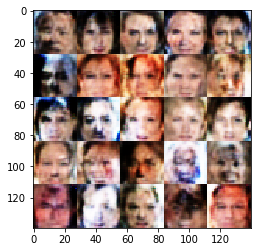

Epoch 0/1... Discriminator Loss: 0.5376... Generator Loss: 1.1428
Epoch 0/1... Discriminator Loss: 0.1065... Generator Loss: 4.6040
Epoch 0/1... Discriminator Loss: 0.3738... Generator Loss: 1.8299
Epoch 0/1... Discriminator Loss: 0.1468... Generator Loss: 2.6497
Epoch 0/1... Discriminator Loss: 1.1112... Generator Loss: 0.7298


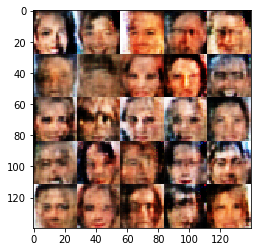

Epoch 0/1... Discriminator Loss: 0.7264... Generator Loss: 1.4253
Epoch 0/1... Discriminator Loss: 1.4957... Generator Loss: 0.9214
Epoch 0/1... Discriminator Loss: 0.6267... Generator Loss: 1.3316
Epoch 0/1... Discriminator Loss: 1.0565... Generator Loss: 1.0664
Epoch 0/1... Discriminator Loss: 0.6889... Generator Loss: 1.0874


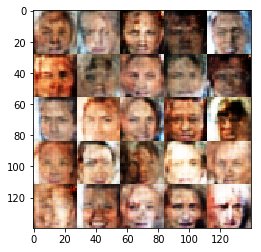

Epoch 0/1... Discriminator Loss: 0.9114... Generator Loss: 0.8992
Epoch 0/1... Discriminator Loss: 0.4996... Generator Loss: 1.5733
Epoch 0/1... Discriminator Loss: 0.5557... Generator Loss: 1.2591
Epoch 0/1... Discriminator Loss: 0.2873... Generator Loss: 1.8144
Epoch 0/1... Discriminator Loss: 0.4877... Generator Loss: 1.3960


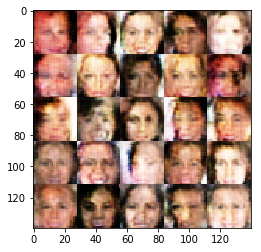

Epoch 0/1... Discriminator Loss: 0.0718... Generator Loss: 3.3736
Epoch 0/1... Discriminator Loss: 0.5702... Generator Loss: 1.2035
Epoch 0/1... Discriminator Loss: 2.1880... Generator Loss: 4.1840
Epoch 0/1... Discriminator Loss: 1.9791... Generator Loss: 3.7878
Epoch 0/1... Discriminator Loss: 0.7537... Generator Loss: 1.4990


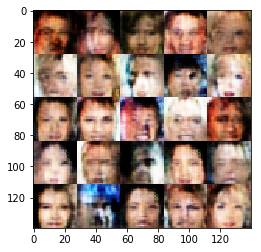

Epoch 0/1... Discriminator Loss: 0.8982... Generator Loss: 1.0605
Epoch 0/1... Discriminator Loss: 0.6394... Generator Loss: 1.4036
Epoch 0/1... Discriminator Loss: 0.8068... Generator Loss: 1.9951
Epoch 0/1... Discriminator Loss: 0.9511... Generator Loss: 2.5074
Epoch 0/1... Discriminator Loss: 0.6496... Generator Loss: 1.6281


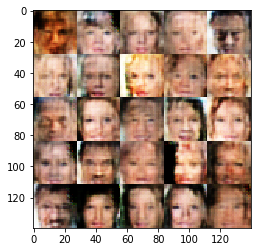

Epoch 0/1... Discriminator Loss: 0.6248... Generator Loss: 1.5624
Epoch 0/1... Discriminator Loss: 0.3917... Generator Loss: 2.9107
Epoch 0/1... Discriminator Loss: 0.6167... Generator Loss: 1.1388
Epoch 0/1... Discriminator Loss: 1.6237... Generator Loss: 0.3572
Epoch 0/1... Discriminator Loss: 3.9351... Generator Loss: 5.6176


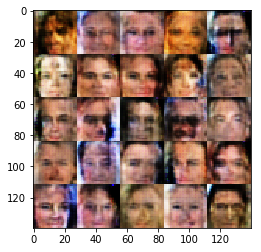

Epoch 0/1... Discriminator Loss: 0.6196... Generator Loss: 1.6017
Epoch 0/1... Discriminator Loss: 0.9319... Generator Loss: 0.6191
Epoch 0/1... Discriminator Loss: 0.5541... Generator Loss: 1.6832
Epoch 0/1... Discriminator Loss: 0.4346... Generator Loss: 2.3167
Epoch 0/1... Discriminator Loss: 2.6500... Generator Loss: 4.5237


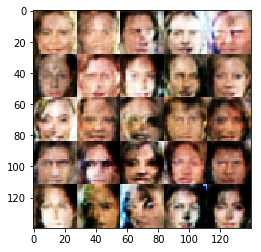

Epoch 0/1... Discriminator Loss: 0.4291... Generator Loss: 2.7480
Epoch 0/1... Discriminator Loss: 0.2857... Generator Loss: 1.7750
Epoch 0/1... Discriminator Loss: 0.8041... Generator Loss: 0.8951
Epoch 0/1... Discriminator Loss: 0.5265... Generator Loss: 1.2023
Epoch 0/1... Discriminator Loss: 0.3806... Generator Loss: 1.5452


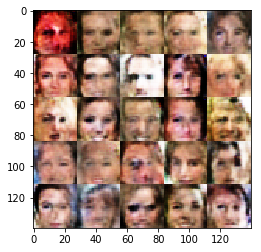

Epoch 0/1... Discriminator Loss: 0.4196... Generator Loss: 5.8027
Epoch 0/1... Discriminator Loss: 0.6323... Generator Loss: 1.0822
Epoch 0/1... Discriminator Loss: 0.4173... Generator Loss: 2.9004
Epoch 0/1... Discriminator Loss: 1.9321... Generator Loss: 3.2455
Epoch 0/1... Discriminator Loss: 0.1013... Generator Loss: 3.1744


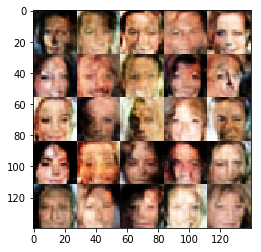

Epoch 0/1... Discriminator Loss: 0.0772... Generator Loss: 3.6083
Epoch 0/1... Discriminator Loss: 0.5191... Generator Loss: 1.5264
Epoch 0/1... Discriminator Loss: 0.2259... Generator Loss: 2.3577
Epoch 0/1... Discriminator Loss: 0.5909... Generator Loss: 3.1658
Epoch 0/1... Discriminator Loss: 1.3935... Generator Loss: 3.0803


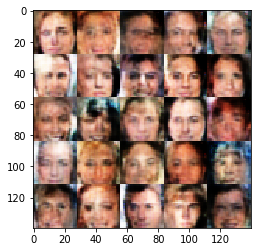

Epoch 0/1... Discriminator Loss: 1.6716... Generator Loss: 0.3337
Epoch 0/1... Discriminator Loss: 0.3674... Generator Loss: 1.5379
Epoch 0/1... Discriminator Loss: 0.3783... Generator Loss: 1.4531
Epoch 0/1... Discriminator Loss: 0.3675... Generator Loss: 2.5509
Epoch 0/1... Discriminator Loss: 0.1674... Generator Loss: 2.5024


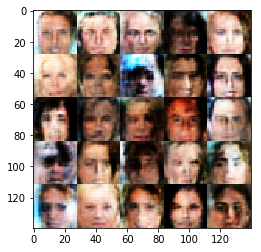

Epoch 0/1... Discriminator Loss: 0.5603... Generator Loss: 2.3022
Epoch 0/1... Discriminator Loss: 0.5547... Generator Loss: 1.1371
Epoch 0/1... Discriminator Loss: 1.3367... Generator Loss: 0.4465
Epoch 0/1... Discriminator Loss: 1.0435... Generator Loss: 2.2947
Epoch 0/1... Discriminator Loss: 1.5160... Generator Loss: 0.3771


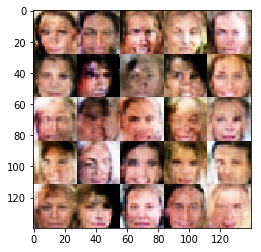

Epoch 0/1... Discriminator Loss: 0.1517... Generator Loss: 2.6110
Epoch 0/1... Discriminator Loss: 1.1803... Generator Loss: 0.5096
Epoch 0/1... Discriminator Loss: 0.1716... Generator Loss: 2.6607
Epoch 0/1... Discriminator Loss: 1.7060... Generator Loss: 0.2597
Epoch 0/1... Discriminator Loss: 0.2818... Generator Loss: 3.6384


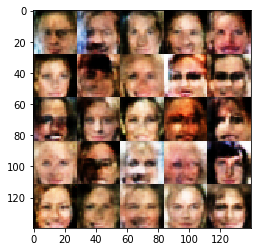

Epoch 0/1... Discriminator Loss: 0.0794... Generator Loss: 3.8070
Epoch 0/1... Discriminator Loss: 0.1393... Generator Loss: 2.8437
Epoch 0/1... Discriminator Loss: 0.2962... Generator Loss: 2.0854
Epoch 0/1... Discriminator Loss: 5.6172... Generator Loss: 8.0180
Epoch 0/1... Discriminator Loss: 0.1602... Generator Loss: 3.4498


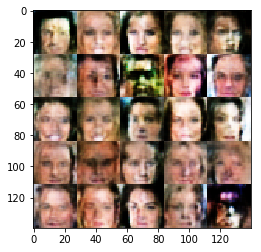

Epoch 0/1... Discriminator Loss: 0.3256... Generator Loss: 3.0482
Epoch 0/1... Discriminator Loss: 1.4080... Generator Loss: 4.9440
Epoch 0/1... Discriminator Loss: 0.3572... Generator Loss: 2.6467
Epoch 0/1... Discriminator Loss: 1.4551... Generator Loss: 0.4640
Epoch 0/1... Discriminator Loss: 0.6535... Generator Loss: 1.4486


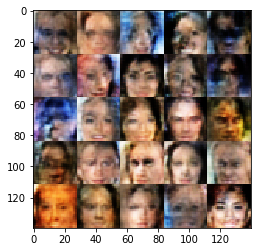

Epoch 0/1... Discriminator Loss: 0.4549... Generator Loss: 3.5043
Epoch 0/1... Discriminator Loss: 2.2818... Generator Loss: 0.1625
Epoch 0/1... Discriminator Loss: 0.3966... Generator Loss: 1.4938
Epoch 0/1... Discriminator Loss: 0.5190... Generator Loss: 2.4179
Epoch 0/1... Discriminator Loss: 0.0999... Generator Loss: 3.4291


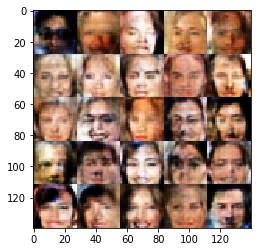

Epoch 0/1... Discriminator Loss: 1.1466... Generator Loss: 0.5794
Epoch 0/1... Discriminator Loss: 0.4129... Generator Loss: 1.7392
Epoch 0/1... Discriminator Loss: 0.2812... Generator Loss: 1.9644
Epoch 0/1... Discriminator Loss: 4.4149... Generator Loss: 6.0323
Epoch 0/1... Discriminator Loss: 0.4468... Generator Loss: 2.4083


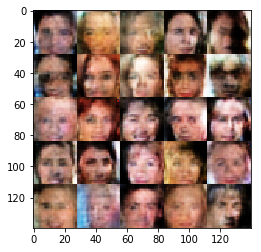

Epoch 0/1... Discriminator Loss: 0.5002... Generator Loss: 1.7562
Epoch 0/1... Discriminator Loss: 0.5126... Generator Loss: 1.8858
Epoch 0/1... Discriminator Loss: 0.5056... Generator Loss: 2.3441
Epoch 0/1... Discriminator Loss: 0.3962... Generator Loss: 3.5650
Epoch 0/1... Discriminator Loss: 0.1712... Generator Loss: 2.4188


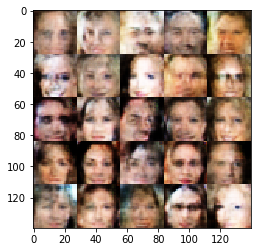

Epoch 0/1... Discriminator Loss: 1.2241... Generator Loss: 1.0062
Epoch 0/1... Discriminator Loss: 0.5595... Generator Loss: 1.3993
Epoch 0/1... Discriminator Loss: 0.8542... Generator Loss: 5.4063
Epoch 0/1... Discriminator Loss: 0.3424... Generator Loss: 1.9258
Epoch 0/1... Discriminator Loss: 0.3567... Generator Loss: 1.7165


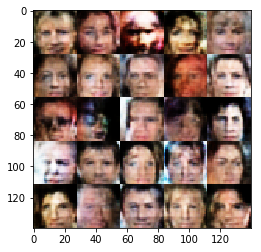

Epoch 0/1... Discriminator Loss: 0.1618... Generator Loss: 3.6967
Epoch 0/1... Discriminator Loss: 0.7176... Generator Loss: 1.3524
Epoch 0/1... Discriminator Loss: 1.0263... Generator Loss: 0.6692
Epoch 0/1... Discriminator Loss: 0.3600... Generator Loss: 2.6052
Epoch 0/1... Discriminator Loss: 0.1579... Generator Loss: 2.4210


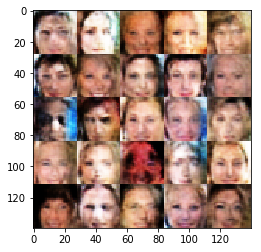

Epoch 0/1... Discriminator Loss: 0.4539... Generator Loss: 2.3128
Epoch 0/1... Discriminator Loss: 0.3696... Generator Loss: 1.8991
Epoch 0/1... Discriminator Loss: 1.1069... Generator Loss: 0.5643
Epoch 0/1... Discriminator Loss: 0.2353... Generator Loss: 2.4994
Epoch 0/1... Discriminator Loss: 0.2317... Generator Loss: 3.4622


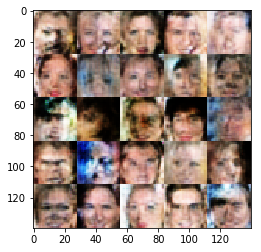

Epoch 0/1... Discriminator Loss: 0.1658... Generator Loss: 2.5529
Epoch 0/1... Discriminator Loss: 0.3062... Generator Loss: 2.2323
Epoch 0/1... Discriminator Loss: 0.7313... Generator Loss: 2.2806
Epoch 0/1... Discriminator Loss: 1.2113... Generator Loss: 0.7744
Epoch 0/1... Discriminator Loss: 0.4859... Generator Loss: 1.8606


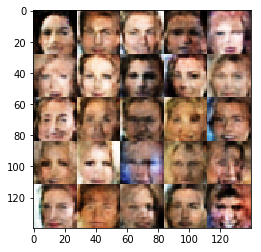

Epoch 0/1... Discriminator Loss: 0.2884... Generator Loss: 2.0516
Epoch 0/1... Discriminator Loss: 0.4363... Generator Loss: 1.4432
Epoch 0/1... Discriminator Loss: 1.6407... Generator Loss: 1.8394
Epoch 0/1... Discriminator Loss: 0.5740... Generator Loss: 4.0846
Epoch 0/1... Discriminator Loss: 0.9331... Generator Loss: 2.2372


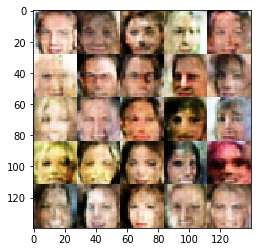

Epoch 0/1... Discriminator Loss: 2.4505... Generator Loss: 0.1793
Epoch 0/1... Discriminator Loss: 0.2436... Generator Loss: 2.7861
Epoch 0/1... Discriminator Loss: 0.7651... Generator Loss: 2.1122
Epoch 0/1... Discriminator Loss: 0.1567... Generator Loss: 2.4945
Epoch 0/1... Discriminator Loss: 0.1562... Generator Loss: 2.6780


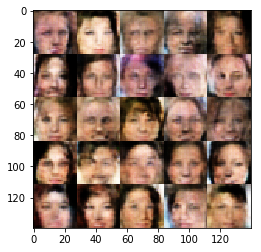

Epoch 0/1... Discriminator Loss: 0.3339... Generator Loss: 1.7190
Epoch 0/1... Discriminator Loss: 0.1715... Generator Loss: 2.9559
Epoch 0/1... Discriminator Loss: 0.0423... Generator Loss: 5.6750
Epoch 0/1... Discriminator Loss: 0.1044... Generator Loss: 4.0687
Epoch 0/1... Discriminator Loss: 0.2120... Generator Loss: 6.0164


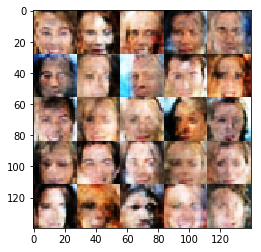

Epoch 0/1... Discriminator Loss: 0.0322... Generator Loss: 4.9696
Epoch 0/1... Discriminator Loss: 1.8501... Generator Loss: 0.3654
Epoch 0/1... Discriminator Loss: 0.4849... Generator Loss: 2.2503
Epoch 0/1... Discriminator Loss: 0.3663... Generator Loss: 2.3454
Epoch 0/1... Discriminator Loss: 1.6323... Generator Loss: 0.5308


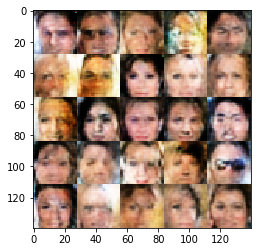

Epoch 0/1... Discriminator Loss: 1.0364... Generator Loss: 0.6897
Epoch 0/1... Discriminator Loss: 0.7508... Generator Loss: 0.9771
Epoch 0/1... Discriminator Loss: 0.9880... Generator Loss: 0.7352
Epoch 0/1... Discriminator Loss: 0.6359... Generator Loss: 1.0333
Epoch 0/1... Discriminator Loss: 0.4622... Generator Loss: 1.3944


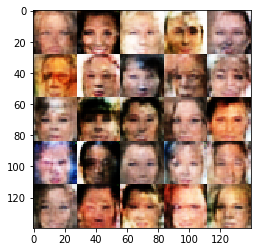

Epoch 0/1... Discriminator Loss: 0.7939... Generator Loss: 0.8883
Epoch 0/1... Discriminator Loss: 0.5519... Generator Loss: 1.3473
Epoch 0/1... Discriminator Loss: 0.6750... Generator Loss: 1.3166
Epoch 0/1... Discriminator Loss: 0.3551... Generator Loss: 2.2098
Epoch 0/1... Discriminator Loss: 0.5657... Generator Loss: 1.0990


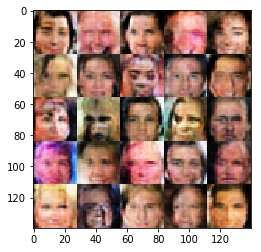

Epoch 0/1... Discriminator Loss: 0.9352... Generator Loss: 0.8602
Epoch 0/1... Discriminator Loss: 1.7895... Generator Loss: 0.3241
Epoch 0/1... Discriminator Loss: 0.6640... Generator Loss: 0.8738
Epoch 0/1... Discriminator Loss: 0.2308... Generator Loss: 2.5010
Epoch 0/1... Discriminator Loss: 0.4624... Generator Loss: 2.5192


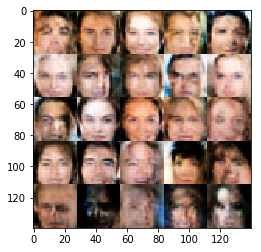

Epoch 0/1... Discriminator Loss: 0.5961... Generator Loss: 1.0993
Epoch 0/1... Discriminator Loss: 0.2284... Generator Loss: 2.3793


In [22]:
batch_size = 64
z_dim = 100
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.